In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Yield_pred/merged_potato_reservoir.csv')

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

# Optional: Summary statistics for numerical columns to check for data consistency
print("\nSummary statistics of the dataset:\n", df.describe())


Missing values per column:
 state_name                     0
crop_name                      0
apy_item_interval_start        0
temperature_recorded_date      0
state_temperature_max_val      0
state_temperature_min_val      0
state_rainfall_val             0
yield                          0
FRL                            0
Live Cap FRL                   0
Level                        382
Current Live Storage         382
dtype: int64
Number of duplicate rows: 0

Summary statistics of the dataset:
        apy_item_interval_start  state_temperature_max_val  \
count             47848.000000               47848.000000   
mean               2014.045645                  33.566005   
std                   5.432290                   5.031233   
min                2000.000000                  11.110000   
25%                2010.000000                  31.070000   
50%                2015.000000                  33.420000   
75%                2019.000000                  36.560000   
max       

In [ ]:
rows_with_missing = df[df.isnull().any(axis=1)]
rows_with_missing.head()

,state_name,crop_name,apy_item_interval_start,temperature_recorded_date,state_temperature_max_val,state_temperature_min_val,state_rainfall_val,yield,FRL,Live Cap FRL,Level,Current Live Storage
2511,Andhra Pradesh,potato,2018,2018-11-16,33.36,18.35,2.73,6.21237,152.296667,2.838333,NaN,NaN
2512,Andhra Pradesh,potato,2018,2018-11-17,33.17,19.03,7.54,6.21237,152.296667,2.838333,NaN,NaN
2513,Andhra Pradesh,potato,2018,2018-11-18,33.87,19.81,1.82,6.21237,152.296667,2.838333,NaN,NaN
2515,Andhra Pradesh,potato,2018,2018-11-20,33.29,19.46,0.00,6.21237,152.296667,2.838333,NaN,NaN
2517,Andhra Pradesh,potato,2018,2018-11-22,31.23,18.05,7.86,6.21237,152.296667,2.838333,NaN,NaN


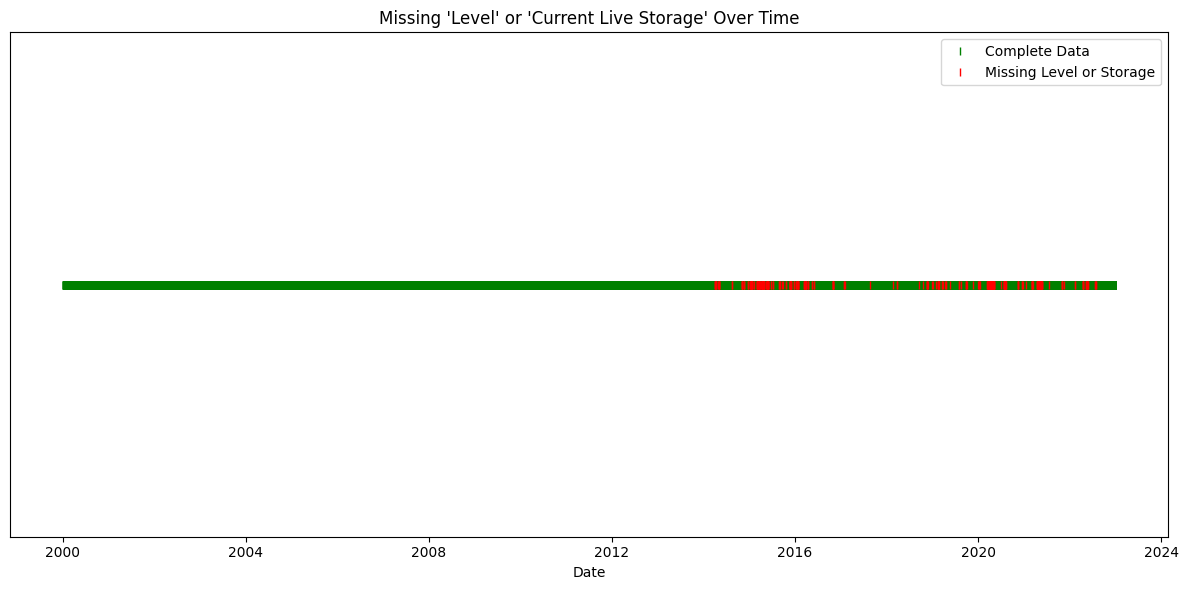

In [ ]:
import matplotlib.pyplot as plt

# Convert date column to datetime format
df['temperature_recorded_date'] = pd.to_datetime(df['temperature_recorded_date'])

# Create a mask for missing values in 'Level' or 'Current Live Storage'
missing_mask = df['Level'].isna() | df['Current Live Storage'].isna()

# Plot missing data points over time
plt.figure(figsize=(12, 6))
plt.plot(df.loc[~missing_mask, 'temperature_recorded_date'], [1]*sum(~missing_mask),
         '|', color='green', label='Complete Data')
plt.plot(df.loc[missing_mask, 'temperature_recorded_date'], [1]*sum(missing_mask),
         '|', color='red', label='Missing Level or Storage')

plt.yticks([])
plt.xlabel("Date")
plt.title("Missing 'Level' or 'Current Live Storage' Over Time")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Ensure the date column is sorted and set as the index for time-based interpolation
df = df.sort_values('temperature_recorded_date')
df = df.set_index(pd.to_datetime(df['temperature_recorded_date']))

# Apply time-based interpolation for the columns with missing values
df['Level'] = df['Level'].interpolate(method='time')
df['Current Live Storage'] = df['Current Live Storage'].interpolate(method='time')

# Reset index back to default
df = df.reset_index(drop=True)

# Check again for missing values to confirm interpolation worked
missing_after_interpolation = df[['Level', 'Current Live Storage']].isnull().sum()
missing_after_interpolation

,0
Level,0
Current Live Storage,0


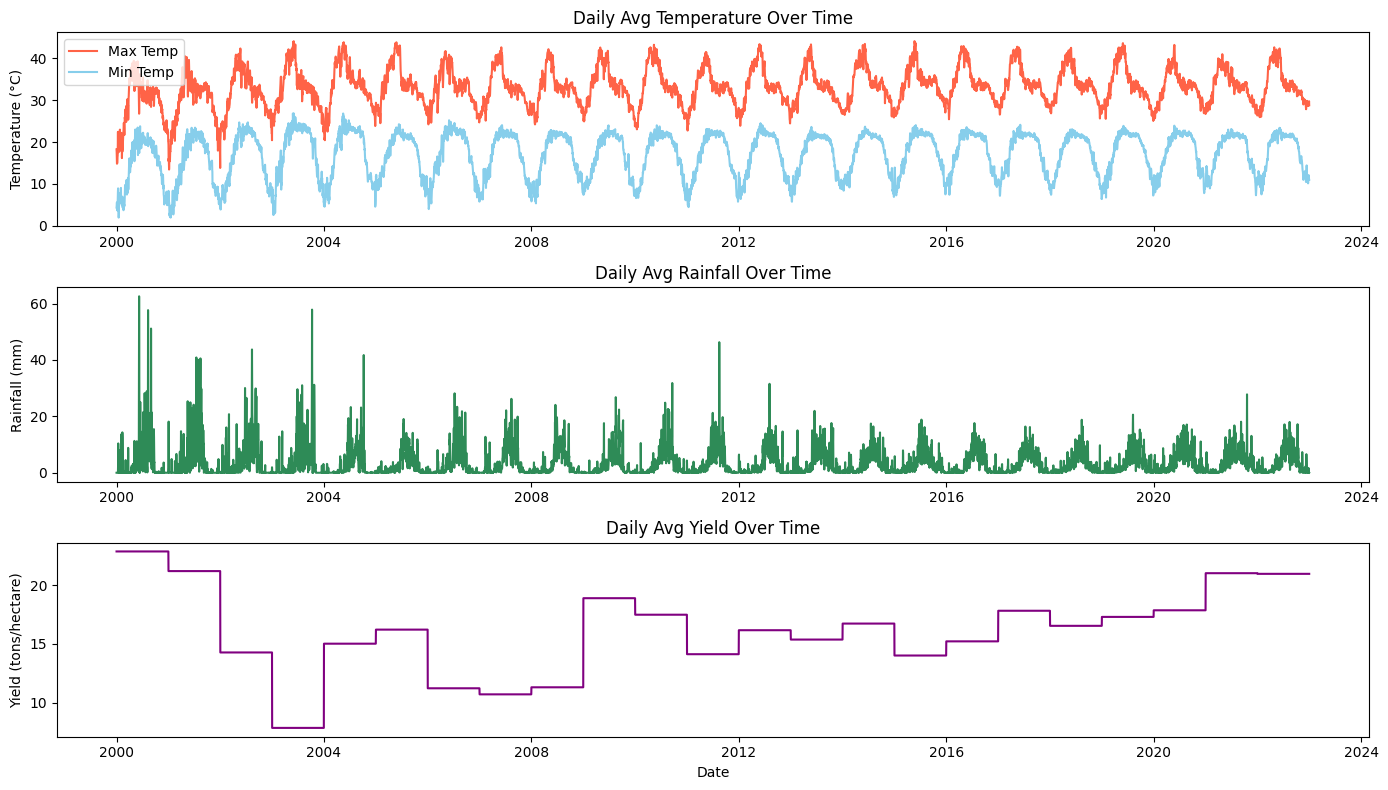

In [ ]:
df['temperature_recorded_date'] = pd.to_datetime(df['temperature_recorded_date'])

# Group by date and compute daily average for temperature, rainfall, and yield
daily_avg = df.groupby('temperature_recorded_date')[[
    'state_temperature_max_val',
    'state_temperature_min_val',
    'state_rainfall_val',
    'yield']].mean()

# Plotting
plt.figure(figsize=(14, 8))

# Max Temperature
plt.subplot(3, 1, 1)
plt.plot(daily_avg.index, daily_avg['state_temperature_max_val'], color='tomato', label='Max Temp')
plt.plot(daily_avg.index, daily_avg['state_temperature_min_val'], color='skyblue', label='Min Temp')
plt.ylabel("Temperature (°C)")
plt.title("Daily Avg Temperature Over Time")
plt.legend()

# Rainfall
plt.subplot(3, 1, 2)
plt.plot(daily_avg.index, daily_avg['state_rainfall_val'], color='seagreen')
plt.ylabel("Rainfall (mm)")
plt.title("Daily Avg Rainfall Over Time")

# Yield
plt.subplot(3, 1, 3)
plt.plot(daily_avg.index, daily_avg['yield'], color='purple')
plt.ylabel("Yield (tons/hectare)")
plt.title("Daily Avg Yield Over Time")
plt.xlabel("Date")

plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

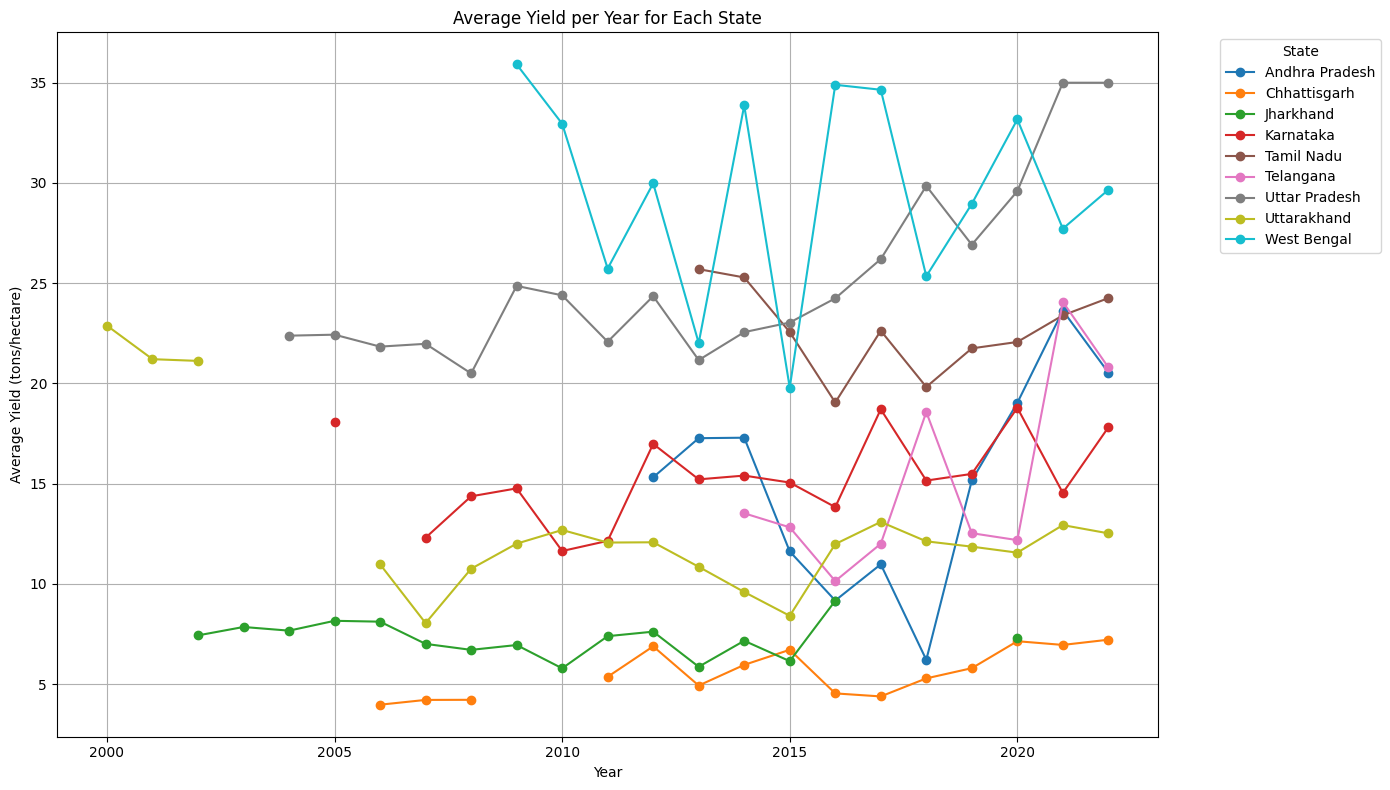

In [ ]:
df['year'] = df['temperature_recorded_date'].dt.year

# Group by 'state_name' and 'year', then compute average yield
state_year_yield = df.groupby(['state_name', 'year'])['yield'].mean().reset_index()

# Pivot table for plotting: index = year, columns = state_name, values = average yield
pivot_yield = state_year_yield.pivot(index='year', columns='state_name', values='yield')

# Plot
plt.figure(figsize=(14, 8))
pivot_yield.plot(marker='o', figsize=(14, 8), colormap='tab10')

plt.title("Average Yield per Year for Each State")
plt.xlabel("Year")
plt.ylabel("Average Yield (tons/hectare)")
plt.grid(True)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

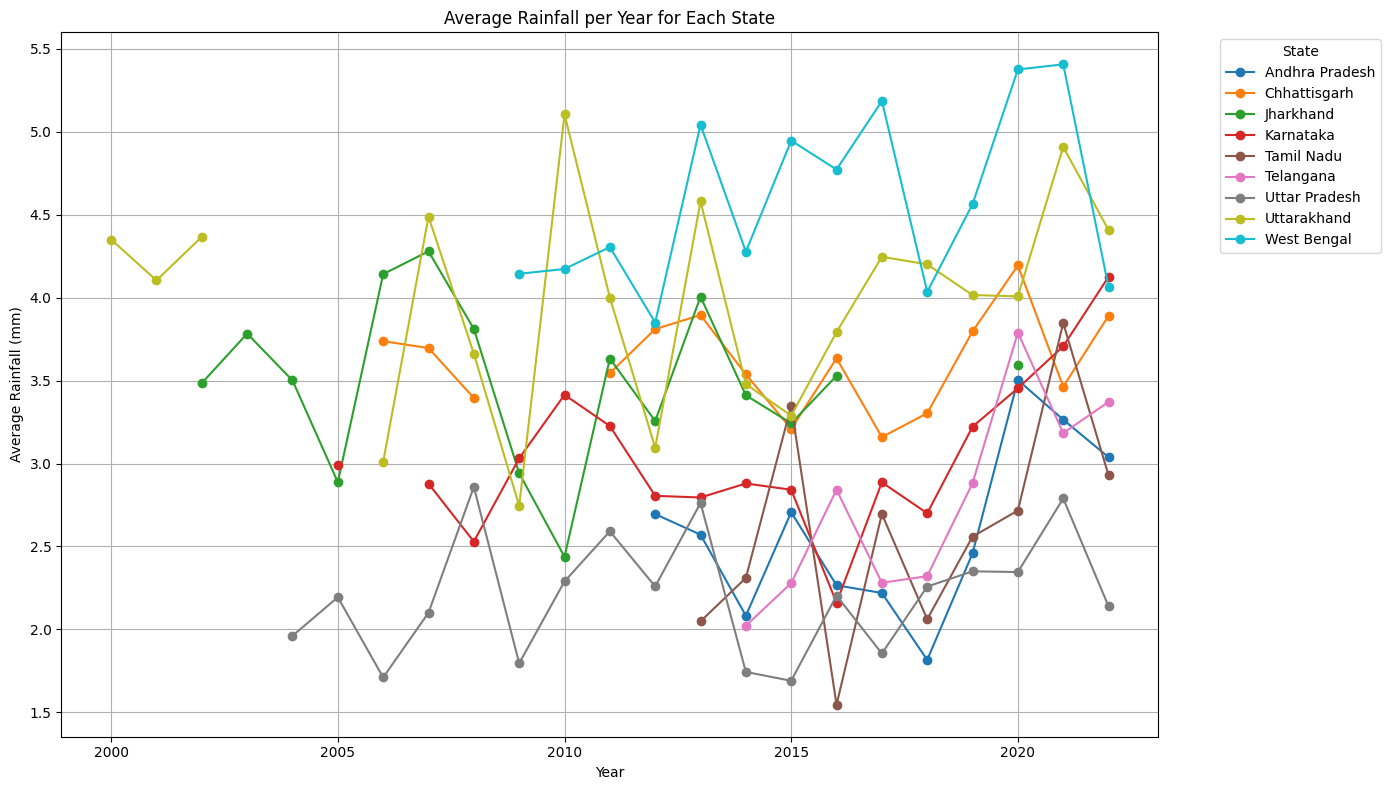

<Figure size 1400x800 with 0 Axes>

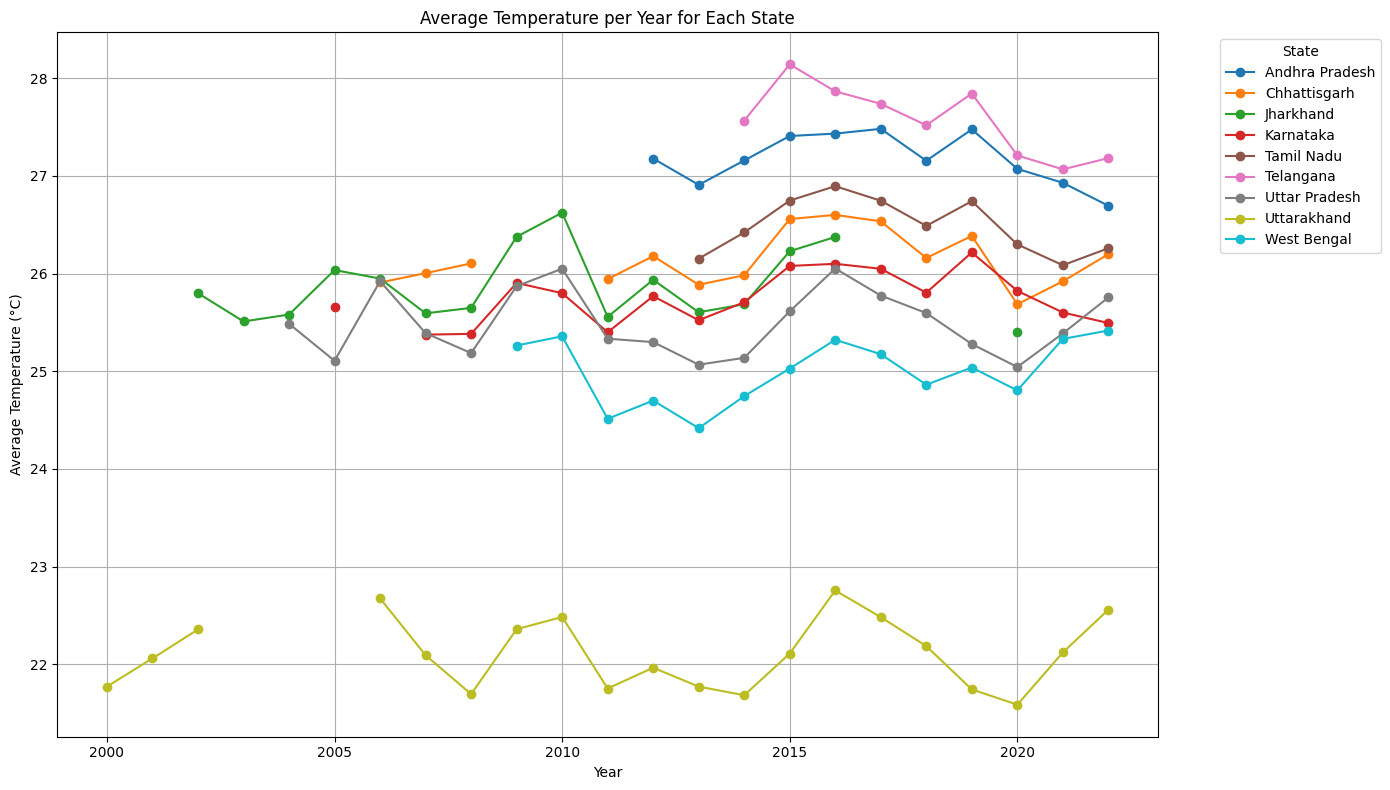

In [ ]:
df['avg_temp'] = (df['state_temperature_max_val'] + df['state_temperature_min_val']) / 2
state_year_stats = df.groupby(['state_name', 'year'])[['state_rainfall_val', 'avg_temp']].mean().reset_index()

# Pivot for rainfall
pivot_rainfall = state_year_stats.pivot(index='year', columns='state_name', values='state_rainfall_val')

# Pivot for temperature
pivot_temp = state_year_stats.pivot(index='year', columns='state_name', values='avg_temp')

# Plotting Rainfall
plt.figure(figsize=(14, 8))
pivot_rainfall.plot(marker='o', figsize=(14, 8), colormap='tab10')
plt.title("Average Rainfall per Year for Each State")
plt.xlabel("Year")
plt.ylabel("Average Rainfall (mm)")
plt.grid(True)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plotting Temperature
plt.figure(figsize=(14, 8))
pivot_temp.plot(marker='o', figsize=(14, 8), colormap='tab10')
plt.title("Average Temperature per Year for Each State")
plt.xlabel("Year")
plt.ylabel("Average Temperature (°C)")
plt.grid(True)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

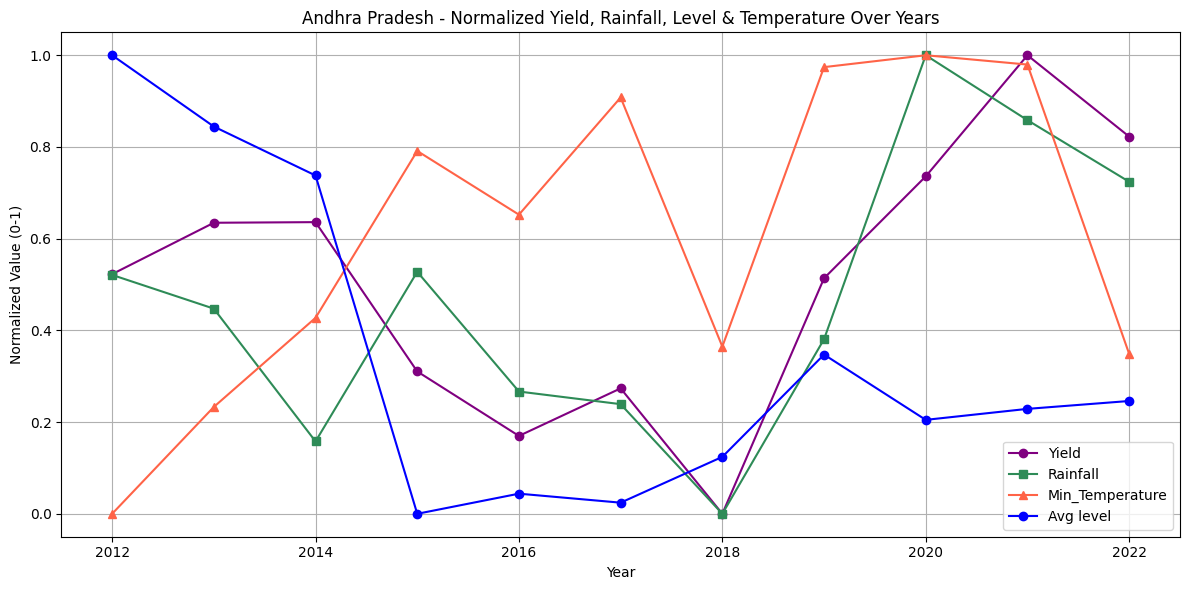

In [ ]:
# Filter Andhra Pradesh
ap_df = df[df['state_name'] == 'Andhra Pradesh']

# Group by year and take average
yearly = ap_df.groupby('year')[['yield', 'state_rainfall_val', 'state_temperature_min_val','Level']].mean().reset_index()

# Normalize each column to [0,1] using min-max scaling
yearly_norm = yearly.copy()
for col in ['yield', 'state_rainfall_val', 'state_temperature_min_val','Level']:
    yearly_norm[col] = (yearly[col] - yearly[col].min()) / (yearly[col].max() - yearly[col].min())

# Plot all three normalized metrics
plt.figure(figsize=(12, 6))
plt.plot(yearly_norm['year'], yearly_norm['yield'], label='Yield', marker='o', color='purple')
plt.plot(yearly_norm['year'], yearly_norm['state_rainfall_val'], label='Rainfall', marker='s', color='seagreen')
plt.plot(yearly_norm['year'], yearly_norm['state_temperature_min_val'], label='Min_Temperature', marker='^', color='tomato')
plt.plot(yearly_norm['year'], yearly_norm['Level'], label='Avg level', marker='o', color='blue')

plt.title("Andhra Pradesh - Normalized Yield, Rainfall, Level & Temperature Over Years")
plt.xlabel("Year")
plt.ylabel("Normalized Value (0-1)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

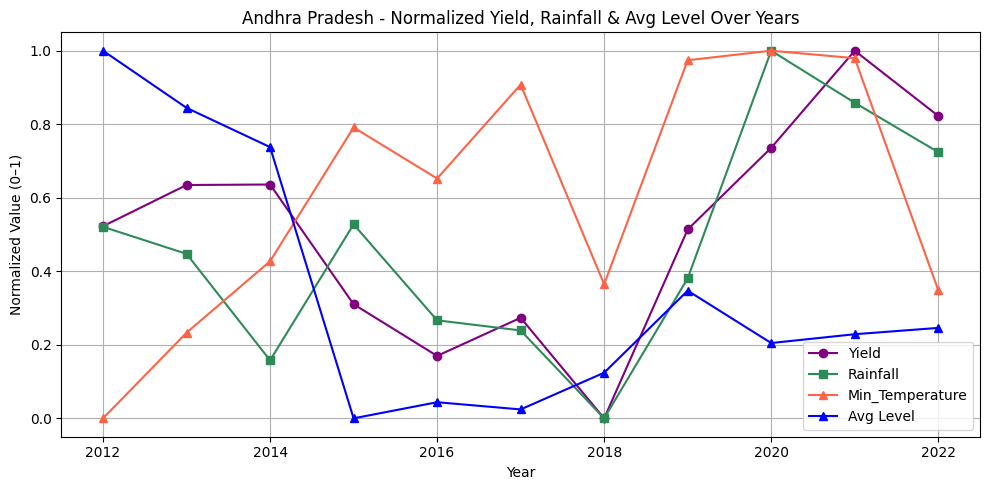

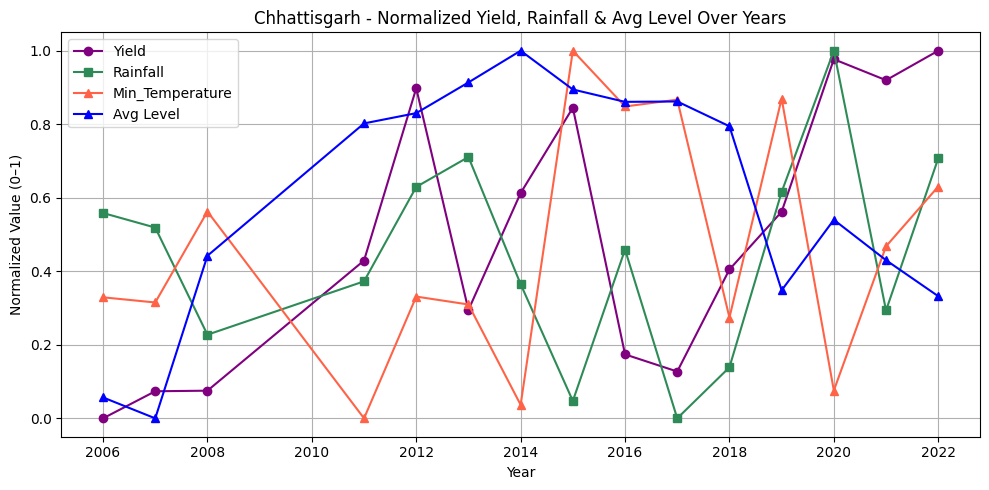

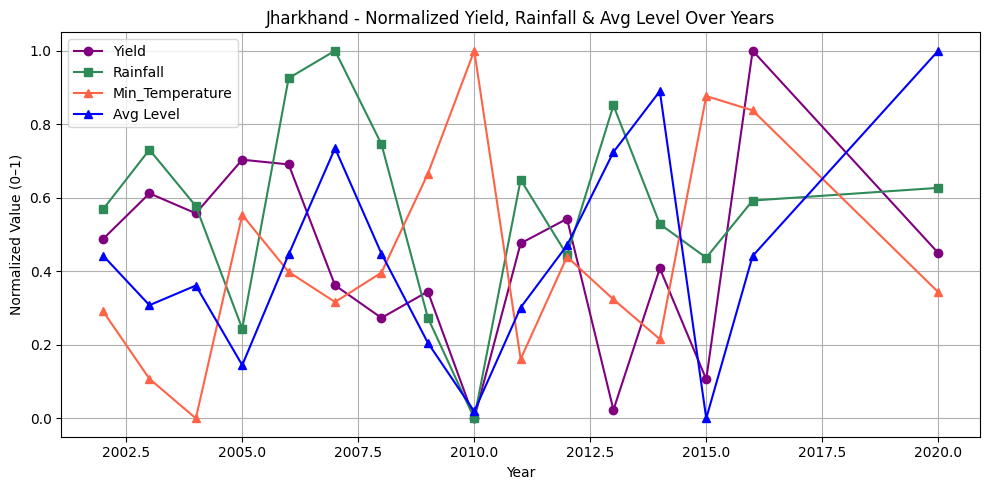

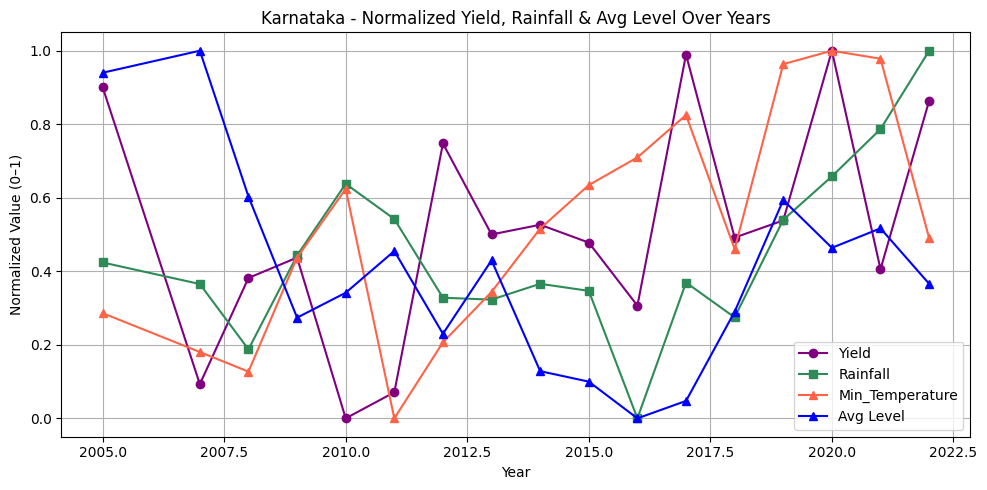

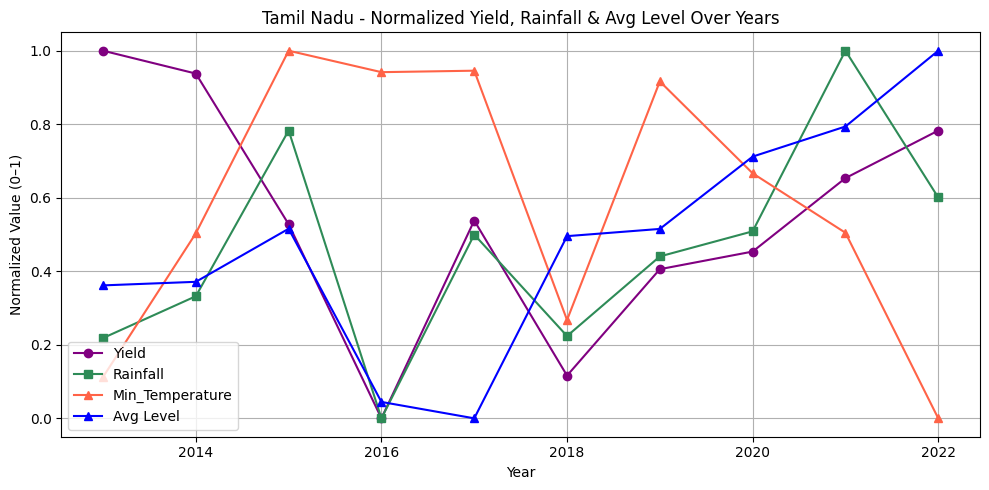

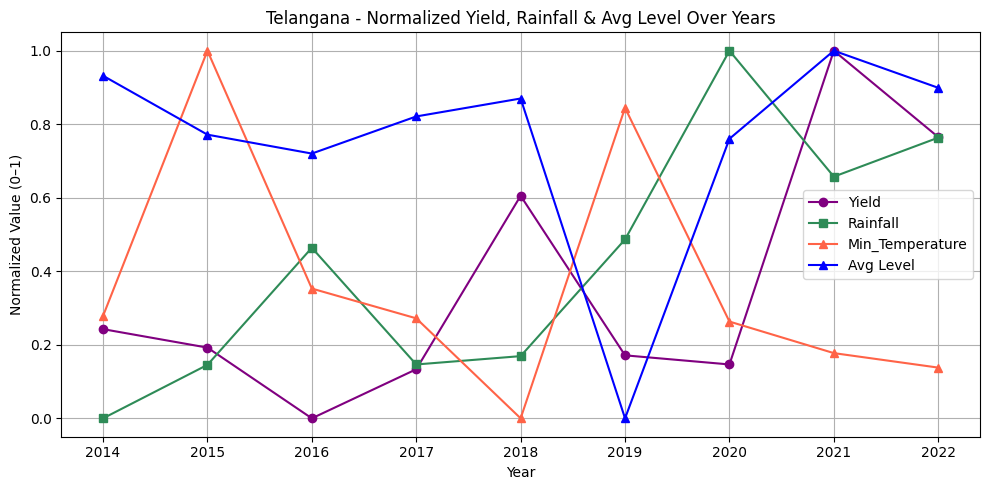

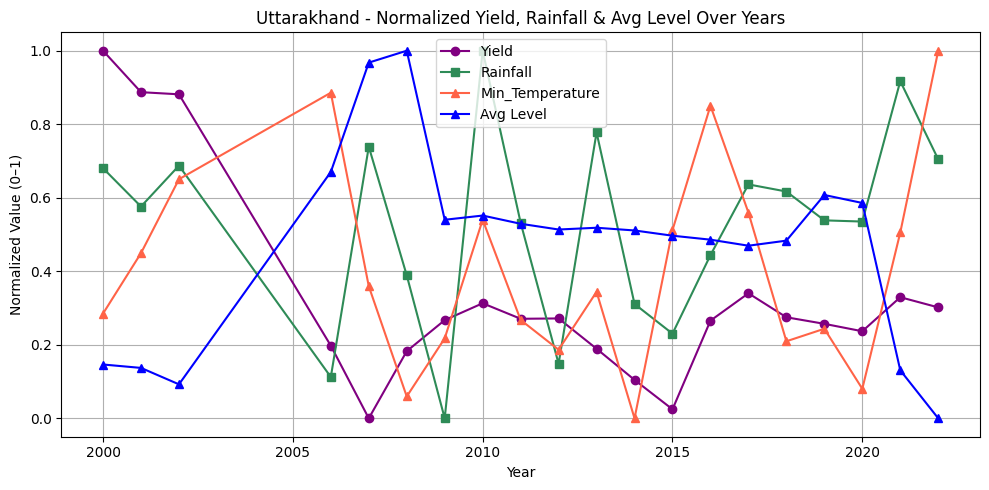

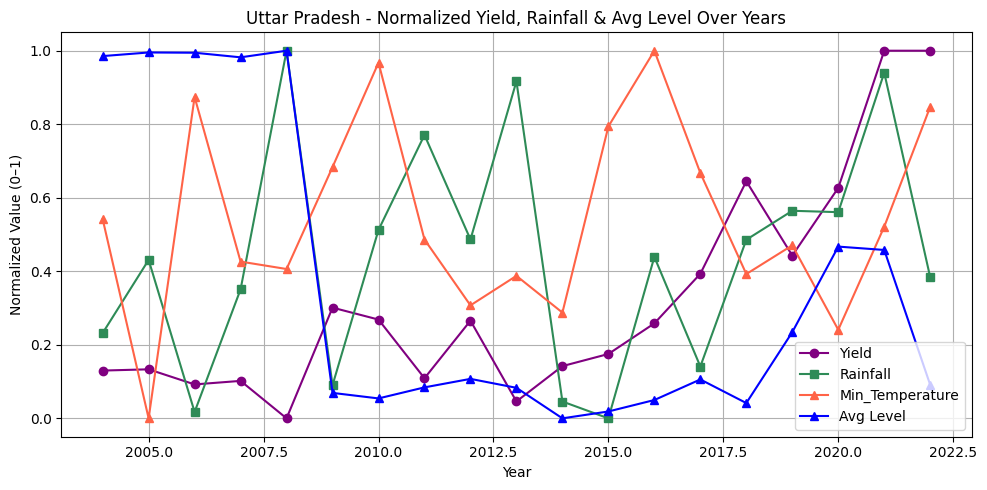

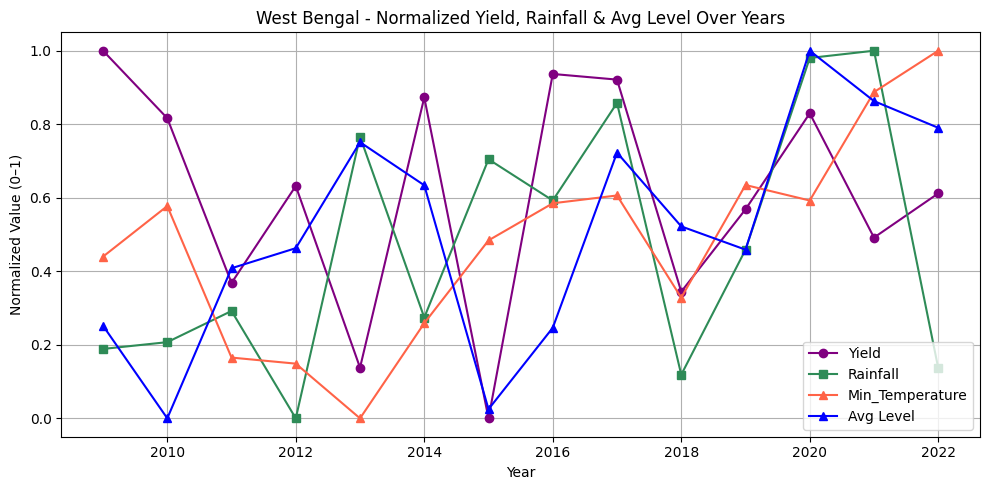

In [ ]:
states = df['state_name'].unique()

# Create a plot for each state
for state in states:
    state_df = df[df['state_name'] == state]

    # Group by year and calculate averages
    yearly = state_df.groupby('year')[['yield', 'state_rainfall_val','state_temperature_min_val', 'Level']].mean().reset_index()

    # Skip states with insufficient data
    if len(yearly) < 3:
        continue

    # Normalize the values
    yearly_norm = yearly.copy()
    for col in ['yield', 'state_rainfall_val','state_temperature_min_val', 'Level']:
        col_min = yearly[col].min()
        col_max = yearly[col].max()
        if col_max != col_min:
            yearly_norm[col] = (yearly[col] - col_min) / (col_max - col_min)
        else:
            yearly_norm[col] = 0.5  # if all values are the same

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(yearly_norm['year'], yearly_norm['yield'], label='Yield', marker='o', color='purple')
    plt.plot(yearly_norm['year'], yearly_norm['state_rainfall_val'], label='Rainfall', marker='s', color='seagreen')
    plt.plot(yearly_norm['year'], yearly_norm['state_temperature_min_val'], label='Min_Temperature', marker='^', color='tomato')
    plt.plot(yearly_norm['year'], yearly_norm['Level'], label='Avg Level', marker='^', color='blue')

    plt.title(f"{state} - Normalized Yield, Rainfall & Avg Level Over Years")
    plt.xlabel("Year")
    plt.ylabel("Normalized Value (0–1)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
#Sample model on potato dataset
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
# Aggregate by year and state
agg_df = df.groupby([ 'year'])[
    ['yield', 'avg_temp', 'state_rainfall_val', 'Level','FRL','Current Live Storage']].mean().dropna().reset_index()
# Define features and target
X = agg_df[['avg_temp', 'state_rainfall_val', 'Level','FRL','Current Live Storage']]
y = agg_df['yield']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)
# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model on test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

model_coef = model.coef_
model_intercept = model.intercept_

# Predict on training set
y_train_pred = model.predict(X_train)

# Evaluate on training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

print("Test Set Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print("\nTraining Set Evaluation:")
print(f"RMSE: {train_rmse:.4f}")
print(f"R² Score: {train_r2:.4f}")

Test Set Evaluation:
RMSE: 2.4390
R² Score: 0.6290

Training Set Evaluation:
RMSE: 1.6290
R² Score: 0.7734


In [ ]:
#model without aggregating data
# Aggregate by year and state
agg_df = df
# One-hot encode the 'state_name'
state_ohe = pd.get_dummies(agg_df['state_name'], prefix='state')
year_ohe = pd.get_dummies(agg_df['year'], prefix='year')

# Combine with features
X = pd.concat([agg_df[['state_temperature_min_val', 'state_rainfall_val', 'Level','FRL','Current Live Storage']], state_ohe,year_ohe], axis=1)
y = agg_df['yield']


# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model on test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

model_coef = model.coef_
model_intercept = model.intercept_

# Predict on training set
y_train_pred = model.predict(X_train)

# Evaluate on training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

print("Test Set Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print("\nTraining Set Evaluation:")
print(f"RMSE: {train_rmse:.4f}")
print(f"R² Score: {train_r2:.4f}")

Test Set Evaluation:
RMSE: 2.7027
R² Score: 0.8966

Training Set Evaluation:
RMSE: 2.6795
R² Score: 0.8984


In [ ]:
df_gram = pd.read_csv('/content/drive/MyDrive/Yield_pred/merged_gram_reservoir.csv')

In [ ]:
df_massor = pd.read_csv('/content/drive/MyDrive/Yield_pred/merged_massor_reservoir.csv')

In [ ]:
df_mustard = pd.read_csv('/content/drive/MyDrive/Yield_pred/merged_mustard_reservoir.csv')

In [ ]:
df_rabi = pd.read_csv('/content/drive/MyDrive/Yield_pred/merged_rabi_rice_reservoir.csv')

In [ ]:
df_wheat = pd.read_csv('/content/drive/MyDrive/Yield_pred/merged_wheat_reservoir.csv')

In [ ]:
dfs=[df_rabi, df_wheat, df_gram, df_massor, df_mustard]
dfs_cleaned = [df.dropna() for df in dfs]
df_rabi, df_wheat, df_gram, df_massor, df_mustard = dfs_cleaned

In [ ]:
merged_df = pd.concat([df, df_rabi, df_wheat, df_gram, df_massor, df_mustard], ignore_index=True)
merged_df['year'] = merged_df['apy_item_interval_start']
merged_df['avg_temp'] = (merged_df['state_temperature_max_val'] + merged_df['state_temperature_min_val']) / 2
state_counts = merged_df['state_name'].value_counts()

valid_states = state_counts[state_counts >= 4000].index.tolist()

state_dfs = {state: merged_df[merged_df['state_name'] == state] for state in valid_states}

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [ ]:
#LinearRegression
#crop feature encoded using target mean

# Store performance per state
state_results = {}

for state, df_state in state_dfs.items():
    # Define X and y
    # 1. Split data first
    train_df, test_df = train_test_split(df_state, test_size=0.2, random_state=42)

# 2. Compute mean yield per state *only on training data*
    crop_mean = train_df.groupby('crop_name')['yield'].mean()

# 3. Map it to both train and test
    train_df['crop_encoded'] = train_df['crop_name'].map(crop_mean)
    test_df['crop_encoded'] = test_df['crop_name'].map(crop_mean)

# 4. (Optional) Fill unknown states in test set (if any)
    test_df['crop_encoded'] = test_df['crop_encoded'].fillna(crop_mean.mean())
    features = ['avg_temp', 'state_rainfall_val', 'Level', 'FRL', 'Current Live Storage','crop_encoded']
    X_train = train_df[features]
    y_train = train_df['yield']

    X_test = test_df[features]
    y_test = test_df['yield']


    # Train Random Forest model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    # Store results
    state_results[state] = {
        'Test RMSE': test_rmse,
        'Test R²': test_r2,
        'Train RMSE': train_rmse,
        'Train R²': train_r2,
        'Model': model
    }

# Display results summary
for state, res in state_results.items():
    print(f"\n📍 {state}")
    print(f"Train R²: {res['Train R²']:.4f} | Train RMSE: {res['Train RMSE']:.4f}")
    print(f"Test  R²: {res['Test R²']:.4f} | Test  RMSE: {res['Test RMSE']:.4f} ")


📍 Uttarakhand
Train R²: 0.8873 | Train RMSE: 1.5831
Test  R²: 0.8839 | Test  RMSE: 1.6466 

📍 Uttar Pradesh
Train R²: 0.9638 | Train RMSE: 1.7425
Test  R²: 0.9623 | Test  RMSE: 1.8186 

📍 Chhattisgarh
Train R²: 0.9334 | Train RMSE: 0.4608
Test  R²: 0.9312 | Test  RMSE: 0.4660 

📍 West Bengal
Train R²: 0.9673 | Train RMSE: 1.7715
Test  R²: 0.9671 | Test  RMSE: 1.7754 

📍 Andhra Pradesh
Train R²: 0.8744 | Train RMSE: 1.6725
Test  R²: 0.8717 | Test  RMSE: 1.6981 

📍 Jharkhand
Train R²: 0.9697 | Train RMSE: 0.4091
Test  R²: 0.9681 | Test  RMSE: 0.4229 

📍 Karnataka
Train R²: 0.9722 | Train RMSE: 0.9185
Test  R²: 0.9731 | Test  RMSE: 0.9086 

📍 Telangana
Train R²: 0.8920 | Train RMSE: 1.4086
Test  R²: 0.8885 | Test  RMSE: 1.4479 

📍 Rajasthan
Train R²: 0.9193 | Train RMSE: 0.2898
Test  R²: 0.9217 | Test  RMSE: 0.2876 

📍 Madhya Pradesh
Train R²: 0.7267 | Train RMSE: 0.4410
Test  R²: 0.7302 | Test  RMSE: 0.4383 

📍 Gujarat
Train R²: 0.8510 | Train RMSE: 0.3036
Test  R²: 0.8574 | Test  RMSE:

In [ ]:
#crop feature encoded using target mean

# Store performance per state
state_results = {}

for state, df_state in state_dfs.items():
    # Define X and y
    # 1. Split data first
    train_df, test_df = train_test_split(df_state, test_size=0.2, random_state=42)

# 2. Compute mean yield per state *only on training data*
    crop_mean = train_df.groupby('crop_name')['yield'].mean()

# 3. Map it to both train and test
    train_df['crop_encoded'] = train_df['crop_name'].map(crop_mean)
    test_df['crop_encoded'] = test_df['crop_name'].map(crop_mean)

# 4. (Optional) Fill unknown states in test set (if any)
    test_df['crop_encoded'] = test_df['crop_encoded'].fillna(crop_mean.mean())
    features = ['avg_temp', 'state_rainfall_val', 'Level', 'FRL', 'Current Live Storage','crop_encoded']
    X_train = train_df[features]
    y_train = train_df['yield']

    X_test = test_df[features]
    y_test = test_df['yield']


    # Train Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    # Store results
    state_results[state] = {
        'Test RMSE': test_rmse,
        'Test R²': test_r2,
        'Train RMSE': train_rmse,
        'Train R²': train_r2,
        'Model': model
    }

# Display results summary
for state, res in state_results.items():
    print(f"\n📍 {state}")
    print(f"Train R²: {res['Train R²']:.4f} | Train RMSE: {res['Train RMSE']:.4f}")
    print(f"Test  R²: {res['Test R²']:.4f} | Test  RMSE: {res['Test RMSE']:.4f} ")


📍 Uttarakhand
Train R²: 0.9972 | Train RMSE: 0.2491
Test  R²: 0.9798 | Test  RMSE: 0.6877 

📍 Uttar Pradesh
Train R²: 0.9981 | Train RMSE: 0.4010
Test  R²: 0.9881 | Test  RMSE: 1.0198 

📍 Chhattisgarh
Train R²: 0.9978 | Train RMSE: 0.0833
Test  R²: 0.9840 | Test  RMSE: 0.2247 

📍 West Bengal
Train R²: 0.9982 | Train RMSE: 0.4199
Test  R²: 0.9879 | Test  RMSE: 1.0786 

📍 Andhra Pradesh
Train R²: 0.9967 | Train RMSE: 0.2714
Test  R²: 0.9824 | Test  RMSE: 0.6282 

📍 Jharkhand
Train R²: 0.9984 | Train RMSE: 0.0955
Test  R²: 0.9863 | Test  RMSE: 0.2771 

📍 Karnataka
Train R²: 0.9976 | Train RMSE: 0.2677
Test  R²: 0.9834 | Test  RMSE: 0.7128 

📍 Telangana
Train R²: 0.9965 | Train RMSE: 0.2530
Test  R²: 0.9779 | Test  RMSE: 0.6440 

📍 Rajasthan
Train R²: 0.9981 | Train RMSE: 0.0446
Test  R²: 0.9869 | Test  RMSE: 0.1177 

📍 Madhya Pradesh
Train R²: 0.9943 | Train RMSE: 0.0635
Test  R²: 0.9604 | Test  RMSE: 0.1679 

📍 Gujarat
Train R²: 0.9952 | Train RMSE: 0.0543
Test  R²: 0.9677 | Test  RMSE:

In [ ]:
#Train-Test splitting by years and using predicted feature values for testing

state_results = {}

# feature names for your yield model
feature_cols = ['avg_temp', 'state_rainfall_val', 'Level', 'FRL', 'Current Live Storage']

for state, df_state in state_dfs.items():
    bad_states = ['Uttar Pradesh', 'Andhra Pradesh', 'Telangana']
    if state in bad_states:
      continue
    # 1. sort by year and split first 80% rows vs last 20%
    df_state = df_state.sort_values('year').reset_index(drop=True)
    split_idx = int(0.8 * len(df_state))
    train_df = df_state.iloc[:split_idx].copy()
    test_df  = df_state.iloc[split_idx:].copy()

    # 2. safe target‐encode 'crop_name' → 'crop_encoded' using only train
    crop_mean = train_df.groupby('crop_name')['yield'].mean()
    train_df['crop_encoded'] = train_df['crop_name'].map(crop_mean)
    test_df['crop_encoded']  = test_df['crop_name'].map(crop_mean).fillna(crop_mean.mean())

    # 3. train your main yield model on true features + crop_encoded
    features = feature_cols + ['crop_encoded']
    X_train_yield = train_df[features]
    y_train_yield = train_df['yield']
    yield_model   = RandomForestRegressor(n_estimators=100, random_state=42)
    yield_model.fit(X_train_yield, y_train_yield)

    # 4. train one simple regressor per feature using only 'year'

    feature_models = {}
    for feat in feature_cols:
        lr = LinearRegression()
        lr.fit(train_df[['year']], train_df[feat])
        feature_models[feat] = lr

    # 5. predict each feature in the test set from its year
    preds = {}
    for feat, fm in feature_models.items():
        preds[feat] = fm.predict(test_df[['year']])


    # 6. build X_test_yield DataFrame with exactly the same columns & order as training
    X_test_yield = pd.DataFrame({feat: preds[feat] for feat in feature_cols})
    X_test_yield['crop_encoded'] = test_df['crop_encoded'].values
    X_test_yield = X_test_yield[features]  # enforce same order

    y_test_yield = test_df['yield']

    # 7. evaluate on test
    y_pred_test = yield_model.predict(X_test_yield)
    test_rmse = mean_squared_error(y_test_yield, y_pred_test)
    test_r2   = r2_score(y_test_yield, y_pred_test)

    # 8. evaluate on train (using same yield_model & training data)
    y_pred_train = yield_model.predict(X_train_yield)
    train_rmse   = mean_squared_error(y_train_yield, y_pred_train)
    train_r2     = r2_score(y_train_yield, y_pred_train)

    # 9. store results
    state_results[state] = {
        'Train RMSE': train_rmse,
        'Train R²'  : train_r2,
        'Test RMSE' : test_rmse,
        'Test R²'   : test_r2
    }

# 10. print a summary
for state, res in state_results.items():
    print(f"\n📍 {state}")
    print(f"Train R²: {res['Train R²']:.4f} | Train RMSE: {res['Train RMSE']:.4f}")
    print(f"Test  R²: {res['Test R²']:.4f} | Test  RMSE: {res['Test RMSE']:.4f} ")


📍 Uttarakhand
Train R²: 0.9983 | Train RMSE: 0.0398
Test  R²: 0.9828 | Test  RMSE: 0.2960 

📍 Chhattisgarh
Train R²: 0.9988 | Train RMSE: 0.0030
Test  R²: 0.8814 | Test  RMSE: 0.6780 

📍 West Bengal
Train R²: 0.9981 | Train RMSE: 0.1625
Test  R²: 0.9859 | Test  RMSE: 1.7630 

📍 Jharkhand
Train R²: 0.9985 | Train RMSE: 0.0094
Test  R²: 0.9027 | Test  RMSE: 0.2022 

📍 Karnataka
Train R²: 0.9982 | Train RMSE: 0.0465
Test  R²: 0.9681 | Test  RMSE: 1.3880 

📍 Rajasthan
Train R²: 0.9992 | Train RMSE: 0.0008
Test  R²: 0.9488 | Test  RMSE: 0.0602 

📍 Madhya Pradesh
Train R²: 0.9949 | Train RMSE: 0.0027
Test  R²: 0.8050 | Test  RMSE: 0.1926 

📍 Gujarat
Train R²: 0.9981 | Train RMSE: 0.0012
Test  R²: 0.5378 | Test  RMSE: 0.2007 

📍 Maharashtra
Train R²: 0.9971 | Train RMSE: 0.0007
Test  R²: 0.5333 | Test  RMSE: 0.1447 

📍 Tamil Nadu
Train R²: 0.9996 | Train RMSE: 0.0341
Test  R²: 0.9946 | Test  RMSE: 0.5986 

📍 Odisha
Train R²: 0.9996 | Train RMSE: 0.0001
Test  R²: 0.4454 | Test  RMSE: 0.0103 


In [ ]:
#LinearRegression
#Train-Test splitting by years and using predicted feature values for testing

state_results = {}

# feature names for your yield model
feature_cols = ['avg_temp', 'state_rainfall_val', 'Level', 'FRL', 'Current Live Storage']

for state, df_state in state_dfs.items():
    bad_states = ['Uttar Pradesh', 'Andhra Pradesh', 'Telangana']
    if state in bad_states:
      continue
    # 1. sort by year and split first 80% rows vs last 20%
    df_state = df_state.sort_values('year').reset_index(drop=True)
    split_idx = int(0.8 * len(df_state))
    train_df = df_state.iloc[:split_idx].copy()
    test_df  = df_state.iloc[split_idx:].copy()

    # 2. safe target‐encode 'crop_name' → 'crop_encoded' using only train
    crop_mean = train_df.groupby('crop_name')['yield'].mean()
    train_df['crop_encoded'] = train_df['crop_name'].map(crop_mean)
    test_df['crop_encoded']  = test_df['crop_name'].map(crop_mean).fillna(crop_mean.mean())

    # 3. train your main yield model on true features + crop_encoded
    features = feature_cols + ['crop_encoded']
    X_train_yield = train_df[features]
    y_train_yield = train_df['yield']
    yield_model   = LinearRegression()
    yield_model.fit(X_train_yield, y_train_yield)

    # 4. train one simple regressor per feature using only 'year'

    feature_models = {}
    for feat in feature_cols:
        lr = LinearRegression()
        lr.fit(train_df[['year']], train_df[feat])
        feature_models[feat] = lr

    # 5. predict each feature in the test set from its year
    preds = {}
    for feat, fm in feature_models.items():
        preds[feat] = fm.predict(test_df[['year']])


    # 6. build X_test_yield DataFrame with exactly the same columns & order as training
    X_test_yield = pd.DataFrame({feat: preds[feat] for feat in feature_cols})
    X_test_yield['crop_encoded'] = test_df['crop_encoded'].values
    X_test_yield = X_test_yield[features]  # enforce same order

    y_test_yield = test_df['yield']

    # 7. evaluate on test
    y_pred_test = yield_model.predict(X_test_yield)
    test_rmse = mean_squared_error(y_test_yield, y_pred_test)
    test_r2   = r2_score(y_test_yield, y_pred_test)

    # 8. evaluate on train (using same yield_model & training data)
    y_pred_train = yield_model.predict(X_train_yield)
    train_rmse   = mean_squared_error(y_train_yield, y_pred_train)
    train_r2     = r2_score(y_train_yield, y_pred_train)

    # 9. store results
    state_results[state] = {
        'Train RMSE': train_rmse,
        'Train R²'  : train_r2,
        'Test RMSE' : test_rmse,
        'Test R²'   : test_r2
    }

# 10. print a summary
for state, res in state_results.items():
    print(f"\n📍 {state}")
    print(f" Train → RMSE: {res['Train RMSE']:.4f}, R²: {res['Train R²']:.4f}")
    print(f"  Test → RMSE: {res['Test RMSE']:.4f}, R²: {res['Test R²']:.4f}")


📍 Uttarakhand
 Train → RMSE: 3.0505, R²: 0.8717
  Test → RMSE: 0.7122, R²: 0.9587

📍 Chhattisgarh
 Train → RMSE: 0.1219, R²: 0.9499
  Test → RMSE: 0.6185, R²: 0.8918

📍 West Bengal
 Train → RMSE: 3.6994, R²: 0.9577
  Test → RMSE: 0.8782, R²: 0.9930

📍 Jharkhand
 Train → RMSE: 0.1841, R²: 0.9710
  Test → RMSE: 0.1480, R²: 0.9288

📍 Karnataka
 Train → RMSE: 0.7599, R²: 0.9711
  Test → RMSE: 1.2955, R²: 0.9702

📍 Rajasthan
 Train → RMSE: 0.0564, R²: 0.9429
  Test → RMSE: 0.1291, R²: 0.8902

📍 Madhya Pradesh
 Train → RMSE: 0.1528, R²: 0.7094
  Test → RMSE: 0.5474, R²: 0.4457

📍 Gujarat
 Train → RMSE: 0.0523, R²: 0.9144
  Test → RMSE: 0.2213, R²: 0.4905

📍 Maharashtra
 Train → RMSE: 0.0209, R²: 0.9154
  Test → RMSE: 0.0366, R²: 0.8821

📍 Tamil Nadu
 Train → RMSE: 1.1018, R²: 0.9865
  Test → RMSE: 0.5450, R²: 0.9951

📍 Odisha
 Train → RMSE: 0.0031, R²: 0.9872
  Test → RMSE: 0.0130, R²: 0.3016


In [ ]:
# Store performance, compare linear regression and RandomForest for random train-test split and predicting using actual features
results = []

for state, df_state in state_dfs.items():
    # Split data
    train_df, test_df = train_test_split(df_state, test_size=0.2, random_state=42)

    # Target encoding for crop
    crop_mean = train_df.groupby('crop_name')['yield'].mean()
    train_df['crop_encoded'] = train_df['crop_name'].map(crop_mean)
    test_df['crop_encoded'] = test_df['crop_name'].map(crop_mean).fillna(crop_mean.mean())

    features = ['avg_temp', 'state_rainfall_val', 'Level', 'FRL', 'Current Live Storage','crop_encoded']
    X_train, y_train = train_df[features], train_df['yield']
    X_test, y_test = test_df[features], test_df['yield']

    # Models to compare
    models = {
        'LR': LinearRegression(),
        'RF': RandomForestRegressor(n_estimators=100, random_state=42)
    }

    # Fit, predict, evaluate for each model
    row = {'State': state}
    for name, model in models.items():
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred  = model.predict(X_test)

        row[f'{name} Train RMSE'] = np.sqrt(mean_squared_error(y_train, y_train_pred))
        row[f'{name} Train R²']   = r2_score(y_train, y_train_pred)
        row[f'{name} Test RMSE']  = np.sqrt(mean_squared_error(y_test, y_test_pred))
        row[f'{name} Test R²']    = r2_score(y_test, y_test_pred)

    results.append(row)

# Create DataFrame and display
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

         State  LR Train RMSE  LR Train R²  LR Test RMSE  LR Test R²  RF Train RMSE  RF Train R²  RF Test RMSE  RF Test R²
   Uttarakhand       1.583138     0.887347      1.646568    0.883942       0.249097     0.997211      0.687708    0.979755
 Uttar Pradesh       1.742486     0.963755      1.818623    0.962261       0.401013     0.998080      1.019810    0.988133
  Chhattisgarh       0.460810     0.933399      0.466045    0.931195       0.083273     0.997825      0.224716    0.984003
   West Bengal       1.771452     0.967269      1.775435    0.967109       0.419865     0.998161      1.078628    0.987860
Andhra Pradesh       1.672503     0.874421      1.698052    0.871731       0.271357     0.996694      0.628160    0.982447
     Jharkhand       0.409126     0.969718      0.422939    0.968140       0.095489     0.998350      0.277078    0.986326
     Karnataka       0.918453     0.972216      0.908613    0.973086       0.267703     0.997640      0.712759    0.983438
     Telangana  

In [ ]:
#Compare models where evaluation is done on predicted test features


# bad states to exclude
bad_states = ['Uttar Pradesh', 'Andhra Pradesh', 'Telangana']

# feature names for yield model
feature_cols = ['avg_temp', 'state_rainfall_val', 'Level', 'FRL', 'Current Live Storage']

# store state-level results
results = []

# store crop-wise predictions
cropwise_preds = []

for state, df_state in state_dfs.items():
    if state in bad_states:
        continue

    # sort by year and split first 80% rows
    df_state = df_state.sort_values('year').reset_index(drop=True)
    split_idx = int(0.8 * len(df_state))
    train_df = df_state.iloc[:split_idx].copy()
    test_df  = df_state.iloc[split_idx:].copy()

    # target encode crop_name
    crop_mean = train_df.groupby('crop_name')['yield'].mean()
    train_df['crop_encoded'] = train_df['crop_name'].map(crop_mean)
    test_df['crop_encoded']  = test_df['crop_name'].map(crop_mean).fillna(crop_mean.mean())

    # train feature prediction models on train_df
    feature_models = {}
    preds = {}
    for feat in feature_cols:
        fm = LinearRegression()
        fm.fit(train_df[['year']], train_df[feat])
        feature_models[feat] = fm
        preds[feat] = fm.predict(test_df[['year']])

    # build predicted test features DataFrame
    X_test_pred_features = pd.DataFrame({feat: preds[feat] for feat in feature_cols})
    X_test_pred_features['crop_encoded'] = test_df['crop_encoded'].values
    X_test_pred_features = X_test_pred_features[feature_cols + ['crop_encoded']]

    # actual test features
    X_test_actual_features = test_df[feature_cols + ['crop_encoded']]
    y_test = test_df['yield']

    # train data
    X_train = train_df[feature_cols + ['crop_encoded']]
    y_train = train_df['yield']

    # compare two models
    models = {
        'LR': LinearRegression(),
        'RF': RandomForestRegressor(n_estimators=100, random_state=42)
    }

    row = {'State': state}
    for name, model in models.items():
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred  = model.predict(X_test_pred_features)

        row[f'{name} Train RMSE'] = mean_squared_error(y_train, y_train_pred)
        row[f'{name} Train R²']   = r2_score(y_train, y_train_pred)
        row[f'{name} Test RMSE']  = mean_squared_error(y_test, y_test_pred)
        row[f'{name} Test R²']    = r2_score(y_test, y_test_pred)

        # ✅ For crop-wise predictions, use RF predictions (or LR if you prefer)
        if name == 'RF':
            test_df_copy = test_df.copy()
            test_df_copy['Predicted Yield'] = y_test_pred
            test_df_copy['State'] = state
            cropwise_preds.append(test_df_copy[['State', 'year', 'crop_name', 'yield', 'Predicted Yield']])

    results.append(row)

    # ✅ If Rajasthan: create and print actual vs predicted feature table for first row
    if state == 'Rajasthan':
        first_actual = X_test_actual_features.iloc[0]
        first_pred   = X_test_pred_features.iloc[0]
        compare_df = pd.DataFrame({
            'Actual Value': first_actual,
            'Predicted Value': first_pred
        })
        print("\n📍 Rajasthan - Actual vs Predicted Features (for first test data point):")
        print(compare_df)

# Create final DataFrame with evaluation metrics
results_df = pd.DataFrame(results)
print("\n📊 Summary Table:")
print(results_df.to_string(index=False))

# Combine crop-wise predictions into single DataFrame
cropwise_df = pd.concat(cropwise_preds, ignore_index=True)





📍 Rajasthan - Actual vs Predicted Features (for first test data point):
                      Actual Value  Predicted Value
avg_temp                 28.140000        26.087362
state_rainfall_val        0.140000         1.931910
Level                   279.644000       284.743750
FRL                     287.252000       287.252000
Current Live Storage      0.451574         0.728505
crop_encoded              1.251720         1.251720

📊 Summary Table:
         State  LR Train RMSE  LR Train R²  LR Test RMSE  LR Test R²  RF Train RMSE  RF Train R²  RF Test RMSE  RF Test R²
   Uttarakhand       3.050504     0.871694      0.712182    0.958732       0.039830     0.998325      0.295978    0.982849
  Chhattisgarh       0.121900     0.949905      0.618529    0.891795       0.002989     0.998771      0.677984    0.881394
   West Bengal       3.699386     0.957748      0.878195    0.992971       0.162505     0.998144      1.763023    0.985888
     Jharkhand       0.184052     0.971026      0.148

In [ ]:
cropwise_summary = cropwise_df.groupby(['crop_name', 'State'], as_index=False).agg({
    'yield': 'mean',
    'Predicted Yield': 'mean'
})
print("\n📊 Aggregated Crop-wise Actual vs Predicted Yields:")
print(cropwise_summary)


📊 Aggregated Crop-wise Actual vs Predicted Yields:
            crop_name           State      yield  Predicted Yield
0                gram    Chhattisgarh   0.693304         0.955106
1                gram         Gujarat   1.691451         1.099751
2                gram       Jharkhand   1.202375         0.998426
3                gram       Karnataka   0.671894         0.598654
4                gram  Madhya Pradesh   1.614275         1.151620
5                gram     Maharashtra   1.030654         0.765881
6                gram          Odisha   0.702796         0.618480
7                gram       Rajasthan   1.075413         0.907155
8                gram      Tamil Nadu   0.926280         0.824060
9                gram     Uttarakhand   0.787872         0.827735
10               gram     West Bengal   1.245962         1.033128
11             masoor    Chhattisgarh   0.710361         0.342319
12             masoor       Jharkhand   0.859635         0.736243
13             masoor  M

In [ ]:
cropwise_summary = cropwise_df.groupby(['crop_name', 'year'], as_index=False).agg({
    'yield': 'mean',
    'Predicted Yield': 'mean'
})
print("\n📊 Aggregated Crop-wise Actual vs Predicted Yields:")
print(cropwise_summary)


📊 Aggregated Crop-wise Actual vs Predicted Yields:
            crop_name  year      yield  Predicted Yield
0                gram  2004   0.626860         0.618480
1                gram  2018   1.008188         0.824798
2                gram  2019   1.039189         0.900636
3                gram  2020   1.123991         0.920867
4                gram  2021   1.137153         0.926313
5                gram  2022   1.108544         0.927649
6              masoor  2004   0.397120         0.414680
7              masoor  2018   0.819200         0.708152
8              masoor  2019   0.816920         0.677634
9              masoor  2020   0.914734         0.735954
10             masoor  2021   0.910728         0.722406
11             masoor  2022   1.205086         0.715014
12             potato  2018  13.724845        13.361661
13             potato  2019  15.525360        15.503793
14             potato  2020  16.351722        14.723173
15             potato  2021  17.109432        17.059

In [ ]:
# Suppose these were your actual training features:
feature_cols = ['avg_temp', 'state_rainfall_val', 'Level', 'FRL', 'Current Live Storage']
features = feature_cols + ['crop_encoded']   # this was used during training

# Get importances
importances = model.feature_importances_

# Now build dataframe
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)


                Feature  Importance
5          crop_encoded    0.986989
2                 Level    0.004776
4  Current Live Storage    0.004277
0              avg_temp    0.002119
1    state_rainfall_val    0.001840
3                   FRL    0.000000
